# Problem Statement:
    Based on people's books suggestions on Reddit (r/booksuggestions), what are similar books that other people have read/suggested? Using NLP and Deep Learning methods, let's analyze those posts and come up with a way to find out what those books are.

## Goals
1. Pull data from Reddit posts (r/booksuggestions)
2. Use adv. NLP methods to analyze data:
    - count most 15-20 read books
    - use cont. skip-grams for most similar books
    - sensitivity analysis to detect similarities
    - cluster similar profils/books
3. TBD

In [564]:
# installing scapy
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
# pip install scapy -U

# pip install streamlit

In [2]:
import pandas as pd
import numpy as np
import os
import requests
import re
import pprint

import spacy #https://scapy.readthedocs.io/en/latest/installation.html#installing-scapy-v2-x
from spacy import displacy
from collections import Counter
import en_core_web_sm

import gensim 
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from pprint import pprint
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk, conlltags2tree, tree2conlltags
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## EDA

In [551]:
# checking directory
os.listdir(path='/Users/ronald_asseko_messa/Google Drive/dsir-125-large-files/')

['df_clean_tagged.csv',
 '.DS_Store',
 'books_clean_df.csv',
 'booksuggestions_clean_df.pkl',
 'booksuggestions_data.csv']

In [3]:
# reading the data file
df = pd.read_pickle('/Users/ronald_asseko_messa/Google Drive/dsir-125-large-files/booksuggestions_clean_df.pkl')

In [4]:
df.head()

,author,title,num_comments,selftext,text,clean_text
0,Spoggy,Looking for Horror fiction that explores the u...,5.0,I love horror films that delve into the outer ...,Looking for Horror fiction that explores the u...,Looking for Horror fiction that explores the u...
1,type2adultdiabeetus,Books that are about or talk about US Army PSYOPS,0.0,"Psyops, an abbreviation of Psychological Opera...",Books that are about or talk about US Army PSY...,Books that are about or talk about US Army PSY...
2,The69thDuncan,Looking for new sci-fi,10.0,So I read a ton of sci-fi and struggle to find...,Looking for new sci-fiSo I read a ton of sci-f...,Looking for new sci-fiSo I read a ton of sci-f...
3,mrjamiemcc,Recommend me my very first book to read,4.0,Being honest. I have never read a book out of ...,Recommend me my very first book to readBeing h...,Recommend me my very first book to readBeing h...
4,FrankenHeart,Started a book club. Suggestions?,19.0,Somehow I became the age of a person that star...,Started a book club. Suggestions?Somehow I bec...,Started a book club. Suggestions?Somehow I bec...


### Identifying Entities

In [6]:
# tokenize words
# changed token to be run on raw text and cleanner version
# since some special characters are used in names, titles ... 
# this version works best 

df['text_tokens'] = df['clean_text'].apply(lambda x: word_tokenize(str(x)))
df.head()

,author,title,num_comments,selftext,text,clean_text,text_tokens
0,Spoggy,Looking for Horror fiction that explores the u...,5.0,I love horror films that delve into the outer ...,Looking for Horror fiction that explores the u...,Looking for Horror fiction that explores the u...,"[Looking, for, Horror, fiction, that, explores..."
1,type2adultdiabeetus,Books that are about or talk about US Army PSYOPS,0.0,"Psyops, an abbreviation of Psychological Opera...",Books that are about or talk about US Army PSY...,Books that are about or talk about US Army PSY...,"[Books, that, are, about, or, talk, about, US,..."
2,The69thDuncan,Looking for new sci-fi,10.0,So I read a ton of sci-fi and struggle to find...,Looking for new sci-fiSo I read a ton of sci-f...,Looking for new sci-fiSo I read a ton of sci-f...,"[Looking, for, new, sci-fiSo, I, read, a, ton,..."
3,mrjamiemcc,Recommend me my very first book to read,4.0,Being honest. I have never read a book out of ...,Recommend me my very first book to readBeing h...,Recommend me my very first book to readBeing h...,"[Recommend, me, my, very, first, book, to, rea..."
4,FrankenHeart,Started a book club. Suggestions?,19.0,Somehow I became the age of a person that star...,Started a book club. Suggestions?Somehow I bec...,Started a book club. Suggestions?Somehow I bec...,"[Started, a, book, club, ., Suggestions, ?, So..."


In [7]:
# # lemmatize clean text
lemma = WordNetLemmatizer() # instantiate lemmatizer

def word_lemmatizer(text):
    lem_text = [lemma.lemmatize(i) for i in text]
    return lem_text

df['text_tokens_lemma'] = df['text_tokens'].apply(lambda x: word_lemmatizer(x))

df.head()

In [557]:
# tag each token with its entity
def word_pos_tagger(text):
    pos_tagged_text = nltk.pos_tag(text)
    return pos_tagged_text

df['tokens_pos_tagged'] = df['text_tokens'].apply(lambda x: word_pos_tagger(x))
df.head()

,author,title,num_comments,selftext,text,clean_text,text_tokens,text_tokens_lemma,tokens_pos_tagged
0,Spoggy,Looking for Horror fiction that explores the u...,5.0,I love horror films that delve into the outer ...,Looking for Horror fiction that explores the u...,Looking for Horror fiction that explores the u...,"[Looking, for, Horror, fiction, that, explores...","[Looking, for, Horror, fiction, that, explores...","[(Looking, VBG), (for, IN), (Horror, NNP), (fi..."
1,type2adultdiabeetus,Books that are about or talk about US Army PSYOPS,0.0,"Psyops, an abbreviation of Psychological Opera...",Books that are about or talk about US Army PSY...,Books that are about or talk about US Army PSY...,"[Books, that, are, about, or, talk, about, US,...","[Books, that, are, about, or, talk, about, US,...","[(Books, NNS), (that, WDT), (are, VBP), (about..."
2,The69thDuncan,Looking for new sci-fi,10.0,So I read a ton of sci-fi and struggle to find...,Looking for new sci-fiSo I read a ton of sci-f...,Looking for new sci-fiSo I read a ton of sci-f...,"[Looking, for, new, sci-fiSo, I, read, a, ton,...","[Looking, for, new, sci-fiSo, I, read, a, ton,...","[(Looking, VBG), (for, IN), (new, JJ), (sci-fi..."
3,mrjamiemcc,Recommend me my very first book to read,4.0,Being honest. I have never read a book out of ...,Recommend me my very first book to readBeing h...,Recommend me my very first book to readBeing h...,"[Recommend, me, my, very, first, book, to, rea...","[Recommend, me, my, very, first, book, to, rea...","[(Recommend, VB), (me, PRP), (my, PRP$), (very..."
4,FrankenHeart,Started a book club. Suggestions?,19.0,Somehow I became the age of a person that star...,Started a book club. Suggestions?Somehow I bec...,Started a book club. Suggestions?Somehow I bec...,"[Started, a, book, club, ., Suggestions, ?, So...","[Started, a, book, club, ., Suggestions, ?, So...","[(Started, VBD), (a, DT), (book, NN), (club, N..."


    Entities with corresponding description:

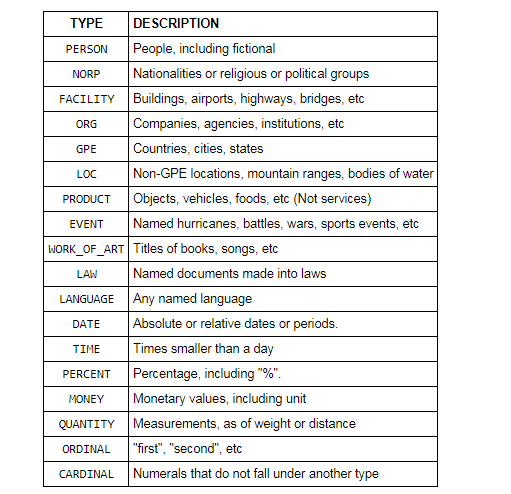

In [9]:
# load nlp english model to analyze entities 
nlp = spacy.load("en_core_web_sm") # nlp = en_core_web_sm.load()

# call entity on first row
nlp(df['clean_text'][0]).ents

(Lovecraft,)

In [11]:
# as an example, let's pull the number of:
# entities, their unique labels, and most common ones

text = '. '.join(df['clean_text'].astype(str))
article = nlp(text[:1_000_000]) # nlp limit is 1_000_000 characters
print('number of entities:',len(article.ents))

labels = [x.label_ for x in article.ents]
print('\n unique labels: \n',Counter(labels))

items = [x.text for x in article.ents]
print('\n most common words: ',Counter(items).most_common(3))

number of entities: 7195

 unique labels: 
 Counter({'PERSON': 2173, 'ORG': 1374, 'DATE': 787, 'CARDINAL': 723, 'GPE': 554, 'WORK_OF_ART': 507, 'NORP': 328, 'ORDINAL': 254, 'LOC': 92, 'EVENT': 90, 'PRODUCT': 74, 'TIME': 64, 'LANGUAGE': 61, 'FAC': 58, 'MONEY': 22, 'PERCENT': 12, 'LAW': 11, 'QUANTITY': 11})

 most common words:  [('first', 154), ('two', 119), ('one', 114)]


We have 507 books in our first 1M characters, while 462 when using raw text and 343 with clean text. Pounctuations, special characters, and numeric values add more books to our list.

In [12]:
# lets select one sentence as an example
sentences = [x for x in article.sents]
print(sentences[30])

Any cool books written by people going insane?I really like Zelda Fitzgerald's art and other artists who were messed up mentally.


In [13]:
# lets now see the raw markup for the sentence above
# colors = {"WORK_OF_ART": "#fc9ce7"}
# options = {"ents": ["WORK_OF_ART"], "colors": {"#fc9ce7"}}

from IPython.core.display import display, HTML

html = displacy.render(nlp(str(sentences[30])), jupyter=True, style='ent', page=True)
display(HTML(html))

# displacy.render(nlp(str(sentences[30])), jupyter=True, style='ent')

<IPython.core.display.HTML object>

In [628]:
os.listdir(path='..//graphs')

['summary of spaCy’s entity types.png']

In [8]:
# pip install --upgrade jupyterthemes
# pip install --upgrade notebook

In [26]:
from pathlib import Path

# display the dependency for the above sentence

dep = displacy.render(nlp(str(sentences[30])), 
                style='dep', jupyter = True, options = {'distance': 140})

# output_path = Path('..//graphs/displacy_2.svg')
# output_path.open("w", encoding="utf-8").write(dep)

Interpretation:

What if we visualize the entire article?

In [26]:
# visualizing the entire article
displacy.render(article, jupyter=True, style='ent')

In [565]:
# checking entites
# any misclassification?
dict([(str(x), x.label_) for x in article.ents])

{'Lovecraft': 'ORG',
 'US Army PSYOPSPsyops': 'ORG',
 'Psychological Operations': 'ORG',
 '2-3 hours': 'TIME',
 'one': 'CARDINAL',
 'Vorkosogian': 'NORP',
 '1': 'CARDINAL',
 '2': 'CARDINAL',
 'Fire Upon the Deep': 'PRODUCT',
 'Ringworld': 'PERSON',
 'Rama': 'GPE',
 'Revelation Space': 'FAC',
 '1984': 'DATE',
 'Forever War': 'EVENT',
 'Terminal': 'NORP',
 'Suns': 'ORG',
 'Neuromancer': 'ORG',
 'Diamond Age': 'ORG',
 'One': 'CARDINAL',
 'first': 'ORDINAL',
 'This summer': 'DATE',
 'Harry Potter': 'PERSON',
 'Rome': 'GPE',
 '30s': 'CARDINAL',
 'the Fantasy/Sci Fi': 'ORG',
 "Zelda Fitzgerald's": 'LOC',
 "Andrew Jackson's": 'PERSON',
 'Dean Koontz': 'PERSON',
 'Kevin O’Brien': 'PERSON',
 'the last two weeks': 'DATE',
 'The Art of War': 'WORK_OF_ART',
 'The Dip': 'WORK_OF_ART',
 'European': 'NORP',
 'Eragon': 'PERSON',
 'Mostly Kerouac': 'PERSON',
 'Dharma Bums': 'PERSON',
 'John Clellon Holmes': 'PERSON',
 'the past 10 or so years': 'DATE',
 'Vladimir Nabokov': 'PERSON',
 'Anton Chekhov': '

"My Neighbor Totoro and Kiki's Delivery Service" should be distinguished as two entities, not one. "Zelda Fitzgerald's" should be a person, not a companie/agency/instituution (Org). 

In [566]:
# saving the list of books
books_sample_1 =  pd.DataFrame([str(x) for x in article.ents if x.label_ in ('WORK_OF_ART')])
books_sample_1.rename(columns = {0: 'book_list'}, inplace=True)
books_sample_1

,book_list
0,The Art of War
1,The Dip
2,Seinfeldia
3,You’re Not Doing It Right”
4,The Pickwick Papers
...,...
502,the A Song of Ice
503,Star Wars
504,a Tale for the Time Being
505,The Song of the Lioness


In [18]:
# detect books from each row
def detect_books(text):
    books = [str(x) for x in nlp(str(text)).ents if x.label_ in ('WORK_OF_ART')]
    return books

df['books_detected'] = df['clean_text'].apply(lambda x: detect_books(x))
df.head()

,author,title,num_comments,selftext,text,clean_text,text_tokens,books_detected
0,Spoggy,Looking for Horror fiction that explores the u...,5.0,I love horror films that delve into the outer ...,Looking for Horror fiction that explores the u...,Looking for Horror fiction that explores the u...,"[Looking, for, Horror, fiction, that, explores...",[]
1,type2adultdiabeetus,Books that are about or talk about US Army PSYOPS,0.0,"Psyops, an abbreviation of Psychological Opera...",Books that are about or talk about US Army PSY...,Books that are about or talk about US Army PSY...,"[Books, that, are, about, or, talk, about, US,...",[]
2,The69thDuncan,Looking for new sci-fi,10.0,So I read a ton of sci-fi and struggle to find...,Looking for new sci-fiSo I read a ton of sci-f...,Looking for new sci-fiSo I read a ton of sci-f...,"[Looking, for, new, sci-fiSo, I, read, a, ton,...",[]
3,mrjamiemcc,Recommend me my very first book to read,4.0,Being honest. I have never read a book out of ...,Recommend me my very first book to readBeing h...,Recommend me my very first book to readBeing h...,"[Recommend, me, my, very, first, book, to, rea...",[]
4,FrankenHeart,Started a book club. Suggestions?,19.0,Somehow I became the age of a person that star...,Started a book club. Suggestions?Somehow I bec...,Started a book club. Suggestions?Somehow I bec...,"[Started, a, book, club, ., Suggestions, ?, So...",[]


Do i have the list of all books? 

    - Any misclassifications? 
        - if so, how do I correct them?
            Using more advanced techniques like Doc2vec
            More cleaning

In [20]:
# put all the books into a df
books = pd.DataFrame([str(x[0]) for x in df['books_detected'] if len(x) > 0], columns=['book_list'])

# books
books

,book_list
0,The Art of War
1,Seinfeldia
2,The Pickwick Papers
3,Terminator
4,How the West was Won
...,...
14018,Catcher in the Rye
14019,"Stars, Looking"
14020,Sleigh
14021,The Hunger Games


The model detected about 14_023 books (864 more than raw text, and 3_041 more than clean text1 - for a total of 13_159, and 10_982 respectively). Some were misclassified!
- Another method might produce a better result

In [21]:
# 20 most popular books
books.value_counts(ascending=False)[:10]

book_list         
Thriller              204
A Song of Ice         171
Love                  159
The Hunger Games      152
Cheers                135
Bible                 110
The Secret History     88
The Book Thief         86
Star Wars              65
Harry Potter           56
dtype: int64

Here are our 20 most popular books

## Modeling

Using Continuous Skip-gram model (from word2vec), a two-layer neural network that:

    - Takes a vector of words as an input.
    - Generates the surrounding "context words" as the output.


In [573]:
# # Train the model! 
corpus = df['text_tokens']

print('instantiate w2v...')
model = Word2Vec(corpus,      # Corpus of data.
                 size=100,    # How many dimensions do you want in your word vector?
                 window=5,    # How many "context words" do you want?
                 min_count=1, # Ignores words below this threshold.
                 sg=1,        # SG = 1 uses SkipGram, SG = 0 uses CBOW (default).
                 workers=4)   # Number of "worker threads" to use (parallelizes process).
print('Done')

instantiate w2v...
Done


In [35]:
# checking the vocabulary of our model
model.wv.vocab

{'Looking': <gensim.models.keyedvectors.Vocab at 0x7fb4f5994f70>,
 'for': <gensim.models.keyedvectors.Vocab at 0x7fb4f5994b50>,
 'Horror': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a63dc0>,
 'fiction': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a63520>,
 'that': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a63f10>,
 'explores': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a63700>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a63550>,
 'uncanny': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a63250>,
 '(': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a60fa0>,
 'Lovecraftian': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a607f0>,
 '?': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a60880>,
 ')': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a60d90>,
 'I': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a603a0>,
 'love': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a60d30>,
 'horror': <gensim.models.keyedvectors.Vocab at 0x7fb4f5a60700>,
 'films': <gensim.models.keyedvectors.Vocab 

In [574]:
# Example of the most similar words
[model.wv.most_similar('Bible')]

[[('Quran', 0.7612322568893433),
  ('Poisonwood', 0.7593402862548828),
  ('Descartes', 0.7567734718322754),
  ('Sisyphus', 0.7411362528800964),
  ('Gulag', 0.7182480096817017),
  ('Bhagavad', 0.715805172920227),
  ('Enlightenment', 0.7142306566238403),
  ('Stoic', 0.7136459350585938),
  ('Economist', 0.7125303745269775),
  ('Socrates', 0.7098446488380432)]]

In [621]:
# define a function that takes in words
# and return the top three books, with the corresponding posts 
# based on cosine similarity

def post_to_book(word, num_books):
    print('tokenizing...')
    tokens = word_tokenize(str(word))
    result = []
    print('computing the cosine similarity...')
    for row in df['text_tokens']:
        result.append(model.wv.n_similarity(tokens, row))
    
    result = pd.DataFrame(result, columns=['similarity_scores'])
    result['similar_text'] = df['clean_text']
    result['similar_tokens'] = df['text_tokens']
    result['list_of_books'] = df['books_detected']
    print('filtering books...')
    result.list_of_books = result.list_of_books.apply(lambda x: np.nan if len(x)==0 else x)
    result_books = result.loc[result['list_of_books'].notna(), :
                             ].sort_values('similarity_scores', ascending=False)[:num_books]
    print('\n top 3 books with scores:')
    print(result_books[['list_of_books', 'similarity_scores']])
    print('\n here is the corresponding data frame...')
    return result_books

### Results

In [592]:
# Lets check out this post
print(df['clean_text'][0])

Looking for Horror fiction that explores the uncanny (Lovecraftian?)I love horror films that delve into the outer reaches of human perception, and present monsters or concepts that avoid the usual cliche of the "tormented spirit" or the "psycho killer". I haven't read any Lovecraft, but I believe his brand of horror is the kind of thing I'm looking for. Any recommendations would be much appreciated.


In [622]:
# using the above text to return the top 3 books
post_to_book(df['clean_text'][0], 3)

tokenizing...
computing the cosine similarity...
filtering books...

 top 3 books with scores:
             list_of_books  similarity_scores
5497   [the Twilight Zone]           0.989369
68435         [The Ritual]           0.988831
64473              [Teeth]           0.988466

 here is the corresponding data frame...


,similarity_scores,similar_text,similar_tokens,list_of_books
5497,0.989369,Any suggestions of some books written before 1...,"[Any, suggestions, of, some, books, written, b...",[the Twilight Zone]
68435,0.988831,books about fictional cults? ; ; Hi there! Rea...,"[books, about, fictional, cults, ?, Hi, there,...",[The Ritual]
64473,0.988466,"Books like the movie ""Jennifer's Body""I've bee...","[Books, like, the, movie, ``, Jennifer, 's, Bo...",[Teeth]


### Conclusion / Suggestions
The model is indeed able to return 3 books based on our word2vec model and using the cosine similarity. The sentence above, "Looking for Horror fiction..." returned "The Twilight Zone", "The Ritual", and "Teeth" with  0.989369, 0.988831, 0.988466 respectively. 

Next: Do more cleaning to the corpus, use a more advanced method like Doc2vec. 